In [54]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [55]:
# get data files, make it able to run locally outside of google colab
import os
import zipfile
from urllib.request import urlretrieve

url = 'https://cdn.freecodecamp.org/project-data/books/book-crossings.zip'
zip_path = 'book-crossings.zip'

if not os.path.exists(zip_path):
    print('Downloading dataset ...')
    urlretrieve(url, zip_path)

print('Extracting ...')
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall('.')

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

Extracting ...


In [56]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

# Strip whitespace from isbn
df_books['isbn'] = df_books['isbn'].str.strip()
df_ratings['isbn'] = df_ratings['isbn'].str.strip()

In [57]:
# add your code here - consider creating a new cell for each section of code

# Filter users with less than 200 ratings and books with less than 100 ratings
user_counts = df_ratings['user'].value_counts()
book_counts = df_ratings['isbn'].value_counts()

df_ratings = df_ratings[df_ratings['user'].isin(user_counts[user_counts >= 200].index)]
df_ratings = df_ratings[df_ratings['isbn'].isin(book_counts[book_counts >= 100].index)]

# Filter books dataframe
df_books = df_books[df_books['isbn'].isin(df_ratings['isbn'].unique())]

# Drop duplicates in df_books
df_books = df_books.drop_duplicates('isbn')

# Create pivot table
ratings_pivot = df_ratings.pivot(index='user', columns='isbn', values='rating').fillna(0)

# Transpose so rows are books, columns are users
ratings_matrix = csr_matrix(ratings_pivot.T.values)

# Fit NearestNeighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(ratings_matrix)

# Create mappings
isbn_to_title = df_books.set_index('isbn')['title'].to_dict()
title_to_index = {}
index_to_title = list(ratings_pivot.columns)
for idx, isbn in enumerate(ratings_pivot.columns):
    if isbn in isbn_to_title:
        title = isbn_to_title[isbn]
        title_to_index[title] = idx

In [58]:
# function to return recommended books - this will be tested
def get_recommends(book=""):
    if book not in title_to_index:
        return [book, []]
    
    idx = title_to_index[book]
    distances, indices = model.kneighbors(ratings_matrix[idx].reshape(1, -1), n_neighbors=6)
    
    recommended = []
    for i in range(1, 6):
        rec_idx = indices[0][i]
        rec_isbn = index_to_title[rec_idx]
        rec_title = df_books[df_books['isbn'] == rec_isbn]['title'].values[0]
        dist = distances[0][i]
        recommended.append([rec_title, dist])
    
    # Sort by distance descending
    recommended = sorted(recommended, key=lambda x: x[1], reverse=True)
    
    return [book, recommended]

In [59]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉


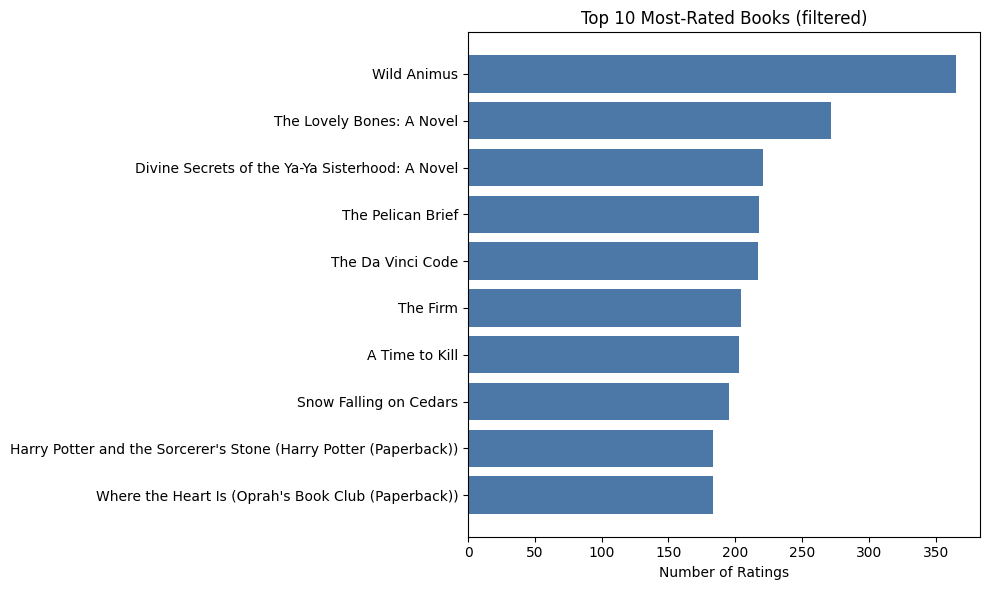

In [60]:
# Visualization: Top 10 most-rated books (after filtering)
top_books = df_ratings['isbn'].value_counts().head(10)
titles = df_books.set_index('isbn').loc[top_books.index, 'title']
plt.figure(figsize=(10, 6))
plt.barh(titles.values[::-1], top_books.values[::-1], color='#4C78A8')
plt.xlabel('Number of Ratings')
plt.title('Top 10 Most-Rated Books (filtered)')
plt.tight_layout()
plt.show()


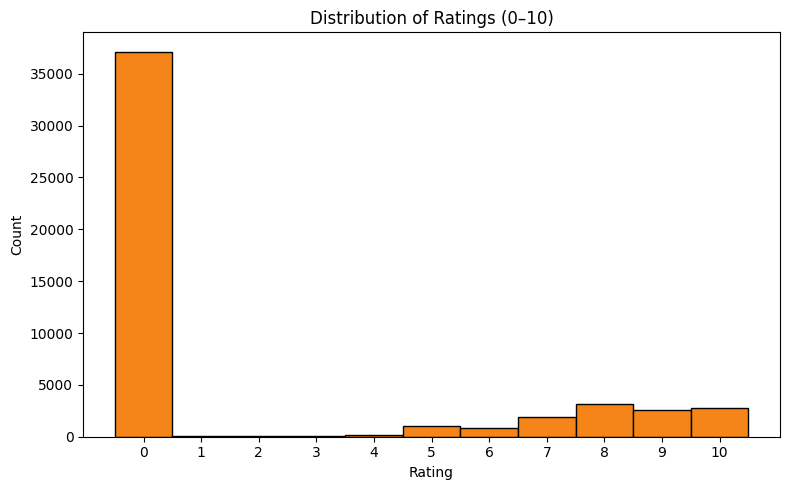

In [61]:
# Visualization: Ratings distribution (filtered)
plt.figure(figsize=(8, 5))
bins = np.arange(-0.5, 11.5, 1)
plt.hist(df_ratings['rating'], bins=bins, edgecolor='black', color='#F58518')
plt.xticks(range(0, 11))
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings (0–10)')
plt.tight_layout()
plt.show()


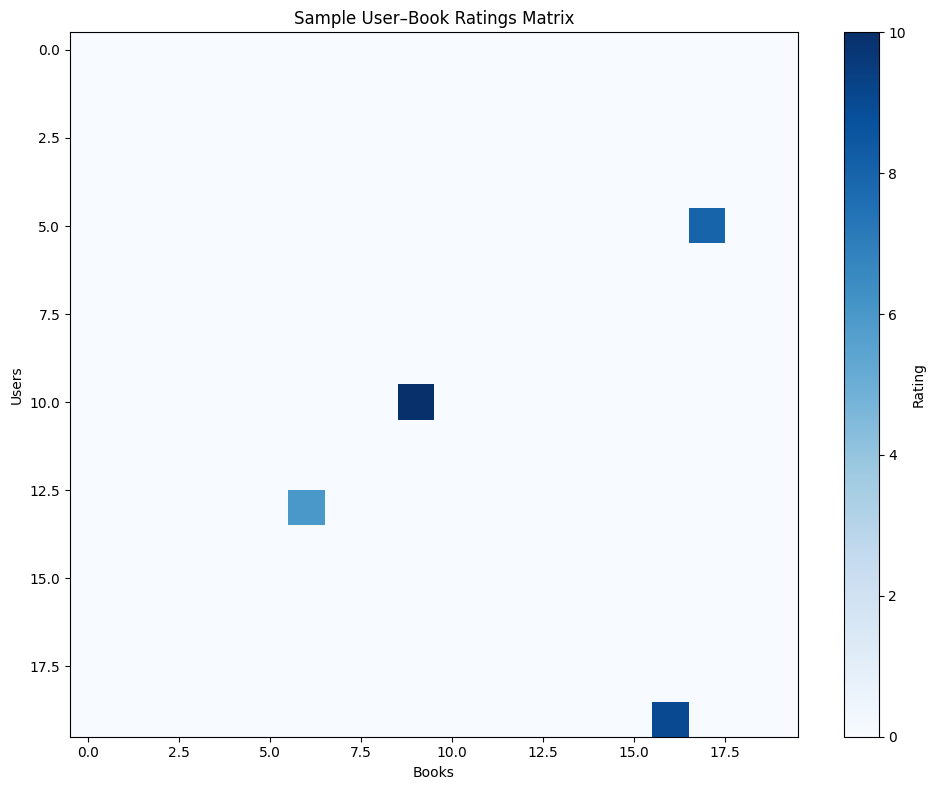

In [62]:
# Visualization: Sample user–book ratings heatmap
rows = int(min(20, ratings_pivot.shape[0]))
cols = int(min(20, ratings_pivot.shape[1]))
sample_users = ratings_pivot.index.to_series().sample(rows, random_state=42)
sample_books = ratings_pivot.columns.to_series().sample(cols, random_state=42)
sample = ratings_pivot.loc[sample_users, sample_books]
plt.figure(figsize=(10, 8))
plt.imshow(sample.values, aspect='auto', cmap='Blues', interpolation='nearest')
plt.colorbar(label='Rating')
plt.xlabel('Books')
plt.ylabel('Users')
plt.title('Sample User–Book Ratings Matrix')
plt.tight_layout()
plt.show()


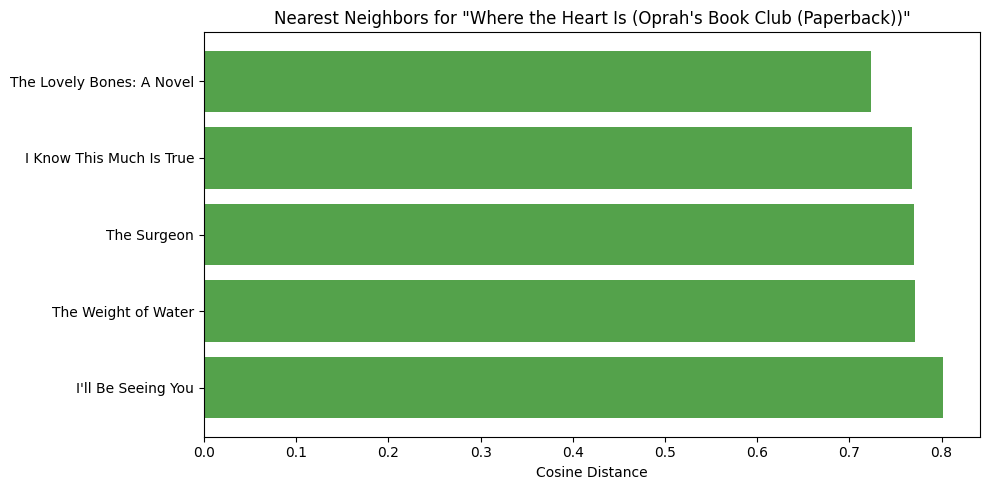

In [63]:
# Visualization: Nearest-neighbor distances for the example book
example_book = "Where the Heart Is (Oprah's Book Club (Paperback))"
if example_book in title_to_index:
    idx = title_to_index[example_book]
    distances, indices = model.kneighbors(ratings_matrix[idx].reshape(1, -1), n_neighbors=6)
    neighbor_isbns = [index_to_title[i] for i in indices[0][1:]]
    neighbor_titles = [df_books[df_books['isbn'] == isbn]['title'].values[0] for isbn in neighbor_isbns]
    neighbor_dists = distances[0][1:]
    plt.figure(figsize=(10, 5))
    plt.barh(neighbor_titles[::-1], neighbor_dists[::-1], color='#54A24B')
    plt.xlabel('Cosine Distance')
    plt.title(f'Nearest Neighbors for "{example_book}"')
    plt.tight_layout()
    plt.show()
else:
    print('Example book not found in index.')
